In [27]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, GroupKFold
import matplotlib.pyplot as plt
import seaborn as sns



In [28]:

print(" Đang đọc dữ liệu từ file 'original_file.csv'...")

try:
    # Đọc file dữ liệu
    df = pd.read_csv("original_file.csv")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'original_file.csv'. Hãy kiểm tra lại đường dẫn.")
    exit()

 Đang đọc dữ liệu từ file 'original_file.csv'...


In [29]:
# Đổi tên cột để dễ xử lý trong code
column_mapping = {
    'numeric_id': 'subject_id',    # Định danh người bệnh
    'FIX_DURATION': 'duration',    # Thời gian nhìn
    'FIX_X': 'x',                  # Tọa độ X
    'FIX_PUPIL': 'pupil',          # 
    'FIX_Y': 'y',                  # Tọa độ Y
    'label': 'label'               # Nhãn (0 hoặc 1)
}

df = df.rename(columns=column_mapping)

In [30]:
print(f"Tổng số dòng dữ liệu: {len(df)}")
df.head(10)

Tổng số dòng dữ liệu: 225159


,IMAGE,FIX_INDEX,duration,x,y,pupil,source_file,subject_id,label,image_id
0,outman_054.jpg,1,205,518.5,371.3,1177,000.xlsx,0,0,53
1,outman_054.jpg,2,90,275.1,282.2,1262,000.xlsx,0,0,53
2,outman_054.jpg,3,305,600.3,271.1,1265,000.xlsx,0,0,53
3,outman_054.jpg,4,269,635.2,269.2,1326,000.xlsx,0,0,53
4,outman_054.jpg,5,318,597.3,266.0,1366,000.xlsx,0,0,53
5,outman_054.jpg,6,585,575.4,269.3,1442,000.xlsx,0,0,53
6,outman_054.jpg,7,531,610.9,274.1,1508,000.xlsx,0,0,53
7,outman_054.jpg,8,336,595.0,333.7,1577,000.xlsx,0,0,53
8,outman_054.jpg,9,400,597.8,599.6,1687,000.xlsx,0,0,53
9,outman_054.jpg,10,325,550.1,580.0,1756,000.xlsx,0,0,53


In [31]:
def extract_features_per_image(df_raw):
    print("Đang trích xuất đặc trưng theo từng ảnh (Trial-based)...")
    features_list = []
    
    # 1. QUAN TRỌNG: Sắp xếp dữ liệu để đảm bảo thứ tự các điểm nhìn đúng theo thời gian
    # Phải sort theo Người -> Ảnh -> Thứ tự điểm nhìn
    df_raw = df_raw.sort_values(by=['subject_id', 'image_id', 'FIX_INDEX'])
    
    # 2. Gom nhóm theo CẶP (Người, Ảnh) thay vì chỉ Người
    grouped = df_raw.groupby(['subject_id', 'image_id'])
    
    for (sub_id, img_id), group in grouped:
        # Bỏ qua nếu quá ít điểm nhìn trong 1 ảnh (nhiễu)
        if len(group) < 3: continue
            
        label = group['label'].iloc[0]
        
        # --- A. TIME ---
        durs = group['duration']
        dur_mean = durs.mean()
        dur_std = durs.std()
        
        # --- B. MOVEMENT & SCANPATH ---
        # Tính khoảng cách giữa các điểm (Saccade amplitude)
        dx = group['x'].diff().fillna(0)
        dy = group['y'].diff().fillna(0)
        dist = np.sqrt(dx**2 + dy**2)
        
        path_length = dist.sum()   # Tổng quãng đường mắt di chuyển trên bức ảnh này
        sac_mean = dist.mean()
        
        # --- C. PUPIL ---
        pupils = group['pupil']
        pupil_mean = pupils.mean()
        pupil_std = pupils.std()
        
        # --- D. SCANPATH TREND (Xu hướng theo thứ tự nhìn) ---
        # Tạo mảng index [0, 1, 2...]
        indices = np.arange(len(group))
        
        # Xem độ giãn đồng tử thay đổi thế nào từ đầu đến cuối bức ảnh
        # Slope > 0: Càng nhìn càng giãn. Slope < 0: Càng nhìn càng co.
        if len(group) > 1:
            slope_pupil = linregress(indices, pupils).slope
            slope_dist = linregress(indices, dist).slope
        else:
            slope_pupil = 0
            slope_dist = 0

        # --- TỔNG HỢP ---
        features_list.append({
            'subject_id': sub_id,
            'image_id': img_id,      # Giữ lại ID ảnh để truy vết nếu cần
            
            'dur_mean': dur_mean,
            'dur_std': dur_std,
            'path_length': path_length,
            'sac_mean': sac_mean,
            'pupil_mean': pupil_mean,
            'pupil_std': pupil_std,
            'slope_pupil': slope_pupil,
            'slope_dist': slope_dist,
            
            'label': label
        })
        
    return pd.DataFrame(features_list)

# Thực hiện
df_features = extract_features_per_image(df)
print(f" Đã xong! Kích thước dữ liệu mới: {df_features.shape}")
print(df_features.head())

Đang trích xuất đặc trưng theo từng ảnh (Trial-based)...
 Đã xong! Kích thước dữ liệu mới: (15701, 11)
   subject_id  image_id    dur_mean     dur_std  path_length    sac_mean  \
0           0         0  224.947368   87.932723  3868.191184  203.589010   
1           0         1  259.058824  143.955927  3165.197599  186.188094   
2           0         2  243.111111  138.325655  4129.817169  229.434287   
3           0         3  269.187500  102.424749  2835.736416  177.233526   
4           0         4  260.176471   92.023934  2454.217500  144.365735   

    pupil_mean   pupil_std  slope_pupil  slope_dist  label  
0  1361.526316  156.283350    18.336842   10.439449      0  
1  1385.705882  203.932821    32.698529    1.999055      0  
2  1401.888889  150.209614    23.923633   17.091437      0  
3  1532.125000  152.788252    25.952941   20.289371      0  
4  1227.823529  142.302159    14.943627    7.648816      0  


 Đang chia dữ liệu Train/Test (theo Subject ID)...
Train set: 12579 mẫu ảnh (dùng để tìm tham số tốt nhất)
Test set:  3122 mẫu ảnh (dùng để kiểm tra độ chính xác thật)

Đang chạy Grid Search để tìm tham số tối ưu...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

THAM SỐ TỐT NHẤT: {'svm__C': 12, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Độ chính xác trên tập Validation (CV Score): 0.7602

KẾT QUẢ ĐÁNH GIÁ THỰC TẾ (SUBJECT LEVEL)
Tổng số bệnh nhân trong tập Test: 32 người
ĐỘ CHÍNH XÁC (ACCURACY): 0.7500 (75.00%)

Báo cáo chi tiết:
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        16
           1       0.90      0.56      0.69        16

    accuracy                           0.75        32
   macro avg       0.79      0.75      0.74        32
weighted avg       0.79      0.75      0.74        32



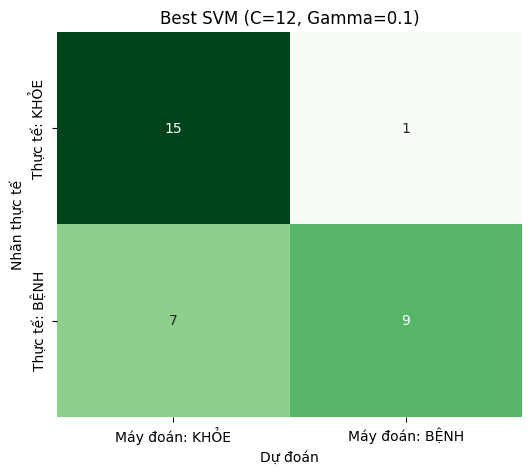

In [ ]:
# X: Các đặc trưng (bỏ ID và Label)
# y: Nhãn (0 hoặc 1)
# groups: ID của người bệnh (QUAN TRỌNG: để chia nhóm không bị lẫn)
X = df_features.drop(columns=['subject_id', 'image_id', 'label'])
y = df_features['label']
groups = df_features['subject_id'] 

#  CHIA TẬP TRAIN VÀ TEST (GIỮ NGUYÊN 20% NGƯỜI ĐỂ TEST CUỐI CÙNG) ---
print(" Đang chia dữ liệu Train/Test (theo Subject ID)...")

# GroupShuffleSplit đảm bảo toàn bộ ảnh của 1 người chỉ nằm ở Train HOẶC Test
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

# Tạo dữ liệu từ index
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]      # Dùng cho Cross-Validation lúc GridSearch
subject_ids_test = groups.iloc[test_idx]   # Dùng để đánh giá cuối cùng

print(f"Train set: {len(X_train)} mẫu ảnh (dùng để tìm tham số tốt nhất)")
print(f"Test set:  {len(X_test)} mẫu ảnh (dùng để kiểm tra độ chính xác thật)")

# --- BƯỚC 4: THIẾT LẬP VÀ CHẠY GRID SEARCH (TÌM C VÀ GAMMA) ---
print("\nĐang chạy Grid Search để tìm tham số tối ưu...")

# Tạo Pipeline: Luôn phải chuẩn hóa (StandardScaler) trước khi vào SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, class_weight='balanced', random_state=42))
])

# Định nghĩa lưới tham số cần duyệt
param_grid = {
    'svm__C': [6, 8, 10, 12, 14],  # Càng lớn càng phạt nặng lỗi sai (dễ overfit), nhỏ thì khái quát hơn
    'svm__gamma': ['scale', 'auto', 0.1, 0.05, 0.15, 0.2], # Độ cong của biên giới hạn
    'svm__kernel': ['rbf'] # RBF là lựa chọn tốt nhất cho dữ liệu phi tuyến tính
}

# GroupKFold: Chia tập Train thành 5 phần để kiểm tra chéo
# Đảm bảo ảnh của 1 người không xuất hiện ở cả phần train con và validation con
gkf = GroupKFold(n_splits=5)

grid = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=gkf, 
    scoring='accuracy', 
    n_jobs=-1, # Chạy song song tất cả nhân CPU cho nhanh
    verbose=1
)

# Bắt đầu training (Truyền groups_train vào để nó biết cách chia)
grid.fit(X_train, y_train, groups=groups_train)

# In kết quả tốt nhất
print(f"\nTHAM SỐ TỐT NHẤT: {grid.best_params_}")
print(f"Độ chính xác trên tập Validation (CV Score): {grid.best_score_:.4f}")

# Lấy ra mô hình quán quân
best_model = grid.best_estimator_

#  ĐÁNH GIÁ CUỐI CÙNG THEO CƠ CHẾ HỘI CHẨN (SOFT VOTING) ---
def evaluate_subject_level(model, X_test, y_test, subject_ids_test):
    print("\n" + "="*40)
    print("KẾT QUẢ ĐÁNH GIÁ THỰC TẾ (SUBJECT LEVEL)")
    print("="*40)

    # 1. Dự đoán xác suất bị bệnh cho từng ảnh
    # Cột [:, 1] là xác suất của lớp 1 (Bệnh)
    probs_img = model.predict_proba(X_test)[:, 1]
    
    # 2. Tạo bảng tạm để gom nhóm
    results_df = pd.DataFrame({
        'subject_id': subject_ids_test.values,
        'true_label': y_test.values,
        'prob_sick': probs_img
    })
    
    # 3. Tính trung bình xác suất của từng người (Gộp các ảnh lại)
    subject_results = results_df.groupby('subject_id').agg({
        'true_label': 'first',   # Nhãn thực tế (luôn giống nhau cho 1 người)
        'prob_sick': 'mean'      # Điểm số trung bình
    }).reset_index()
    
    # 4. Ra quyết định: Nếu điểm trung bình > 0.5 thì kết luận BỆNH
    subject_results['final_pred'] = (subject_results['prob_sick'] > 0.59).astype(int)
    
    # 5. Tính độ chính xác
    final_acc = accuracy_score(subject_results['true_label'], subject_results['final_pred'])
    
    print(f"Tổng số bệnh nhân trong tập Test: {len(subject_results)} người")
    print(f"ĐỘ CHÍNH XÁC (ACCURACY): {final_acc:.4f} ({final_acc*100:.2f}%)")
    
    # In báo cáo chi tiết
    print("\nBáo cáo chi tiết:")
    print(classification_report(subject_results['true_label'], subject_results['final_pred']))
    
    # Vẽ biểu đồ
    cm = confusion_matrix(subject_results['true_label'], subject_results['final_pred'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=['Máy đoán: KHỎE', 'Máy đoán: BỆNH'],
                yticklabels=['Thực tế: KHỎE', 'Thực tế: BỆNH'])
    plt.title(f'Best SVM (C={grid.best_params_["svm__C"]}, Gamma={grid.best_params_["svm__gamma"]})')
    plt.ylabel('Nhãn thực tế')
    plt.xlabel('Dự đoán')
    plt.show()

# Chạy hàm đánh giá
evaluate_subject_level(best_model, X_test, y_test, subject_ids_test)

In [33]:
from sklearn.metrics import f1_score

def find_best_threshold(model, X_test, y_test, subject_ids_test):
    print("\n" + "="*40)
    print("⚖️ TỐI ƯU HÓA NGƯỠNG QUYẾT ĐỊNH (THRESHOLD TUNING)")
    print("="*40)
    
    # 1. Lấy lại xác suất từ mô hình
    probs_img = model.predict_proba(X_test)[:, 1]
    
    # 2. Gom nhóm theo người (giống bước trước)
    df_temp = pd.DataFrame({
        'subject_id': subject_ids_test.values,
        'true_label': y_test.values,
        'prob_sick': probs_img
    })
    
    subject_agg = df_temp.groupby('subject_id').agg({
        'true_label': 'first',
        'prob_sick': 'mean'
    }).reset_index()
    
    y_true = subject_agg['true_label']
    y_scores = subject_agg['prob_sick']
    
    # 3. Chạy vòng lặp thử các ngưỡng từ 0.3 đến 0.7
    best_acc = 0
    best_thresh = 0.5
    
    print(f"{'Threshold':<10} {'Accuracy':<10} {'Recall (Bệnh)':<15} {'F1-Score':<10}")
    print("-" * 50)
    
    for thresh in np.arange(0.3, 0.71, 0.05):
        y_pred = (y_scores >= thresh).astype(int)
        
        acc = accuracy_score(y_true, y_pred)
        recall = classification_report(y_true, y_pred, output_dict=True)['1']['recall']
        f1 = f1_score(y_true, y_pred)
        
        print(f"{thresh:.2f}       {acc:.4f}     {recall:.4f}          {f1:.4f}")
        
        # Chọn ngưỡng có Accuracy cao nhất (hoặc ưu tiên Recall tùy bạn)
        if acc > best_acc:
            best_acc = acc
            best_thresh = thresh
            
    print("-" * 50)
    print(f"✅ Ngưỡng tốt nhất tìm được: {best_thresh}")
    print(f"🚀 Độ chính xác mới: {best_acc:.4f} ({best_acc*100:.2f}%)")
    
    return best_thresh

# --- CHẠY HÀM ---
best_thresh = find_best_threshold(best_model, X_test, y_test, subject_ids_test)


⚖️ TỐI ƯU HÓA NGƯỠNG QUYẾT ĐỊNH (THRESHOLD TUNING)
Threshold  Accuracy   Recall (Bệnh)   F1-Score  
--------------------------------------------------
0.30       0.6562     0.9375          0.7317
0.35       0.6250     0.7500          0.6667
0.40       0.6562     0.6875          0.6667
0.45       0.6562     0.6250          0.6452
0.50       0.7188     0.6250          0.6897
0.55       0.7188     0.5625          0.6667
0.60       0.7500     0.5625          0.6923
0.65       0.6562     0.3750          0.5217
0.70       0.6562     0.3750          0.5217
--------------------------------------------------
✅ Ngưỡng tốt nhất tìm được: 0.5999999999999999
🚀 Độ chính xác mới: 0.7500 (75.00%)
